---
# <div align="center"><font color='green'> Assignment 2 | Introduction to Machine Learning  </font></div>
## <div align="center"> <font color='green'> By: Adhiraj Jain (s3821245) & Jainam Harshal Doshi (s3825891)</font></div>
---


# Classify Images of Cancer

The use of machine learning technology in the biotech industry has rapidly increased over the past decade. The ability to have powerful predictive models that can identify potential issues in the human body has been a major breakthrough, and has helped save countless lives. This report will be focusing on classifying histopathology images of cancerous and non-cancerous cells. The dataset used for this report is a modified version of "CRCHistoPhenotypes" dataset containing many 27x27 RGB images of patients. 

**NOTE**: Please restart the kernel and run all the cells to see outputs and graphs

# Imports <a name="imports"></a>
The following are python libraries are imported:

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
import shutil
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from IPython.display import display

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory

from skimage.filters import gaussian
from skimage.color import rgba2rgb, rgb2gray
from skimage.io import imread

from tensorflow.keras import metrics
import tensorflow_addons as tfa

import keras_tuner

import kerastuner as kt

from keras.models import Model

In [4]:
ALL_IMAGES_DIR = './Image_classification_data/patch_images/'

# Loading Dataset <a name="loading_dataset"></a>

In [5]:
raw_dataset = pd.read_csv('./Image_classification_data/data_labels_mainData.csv')
raw_dataset.info()
RANDOM_STATE = 1234

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


From the metadata above, the dataset has 6 columns and 9896 rows. The dataset has 2 target value, `isCancerous` and `cellType` (the coloumn `cellTypeName` is a string representation of the column `cellType`). The `ImageName` column in the dataset are name of images which be the input features to the machine learning models. Columns `InstanceID` and `patientID` are classified as identifiers. 

In additional, below is an insight the dataset:

In [6]:
raw_dataset.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


# Cleaning the dataset

When constructing a machine learning model, it is very important to clean the dataset. Many datasets usually have missing values, duplicate values, or even incorrect values. Therefore, it is required to implement some cleaning procedures that make the dataset more robust and accurate for machine learning models. However, in this case, the dataset is already cleaned and does not require any further cleaning.

Furthermore, identifiers have no real meaning to the machine learning models and can be removed. The `InstanceID` and `patientID` columns will be removed from the dataset.

In [7]:
# A function to drop any column from the given dataframe.
# Function return a dataframe with the given column name and a list of the column which is dropped

def drop_column(data, column_name):
    return data.drop([column_name], axis=1), data[column_name]

# Dropping ID columns from the dataset
dataset, instanceID = drop_column(raw_dataset, 'InstanceID')
dataset, patientID = drop_column(dataset, 'patientID')

# Exploratory Data Analysis (EDA) <a name="eda"></a>

Before building machine learning models, it is essential to perform exploratory data analysis (EDA) on the dataset. EDA is a process of analyzing the dataset to summarize their main characteristics, often using statistical graphics and other data visualization methods. The main purpose of EDA is to understand the dataset, identify patterns, and spot anomalies. Although EDA will not help construct machine learning models, but it is very critical step to do as it help to make modeling decisions. 

## Image Samples <a id="image_samples"></a>

The main focus of this report is to build machine learning models that can classify different type of cell images. Therefore, it is important to visualize the images in the dataset. Below is a sample of 100 images from the dataset. Each image is a size of 27x27 RGB pixels.

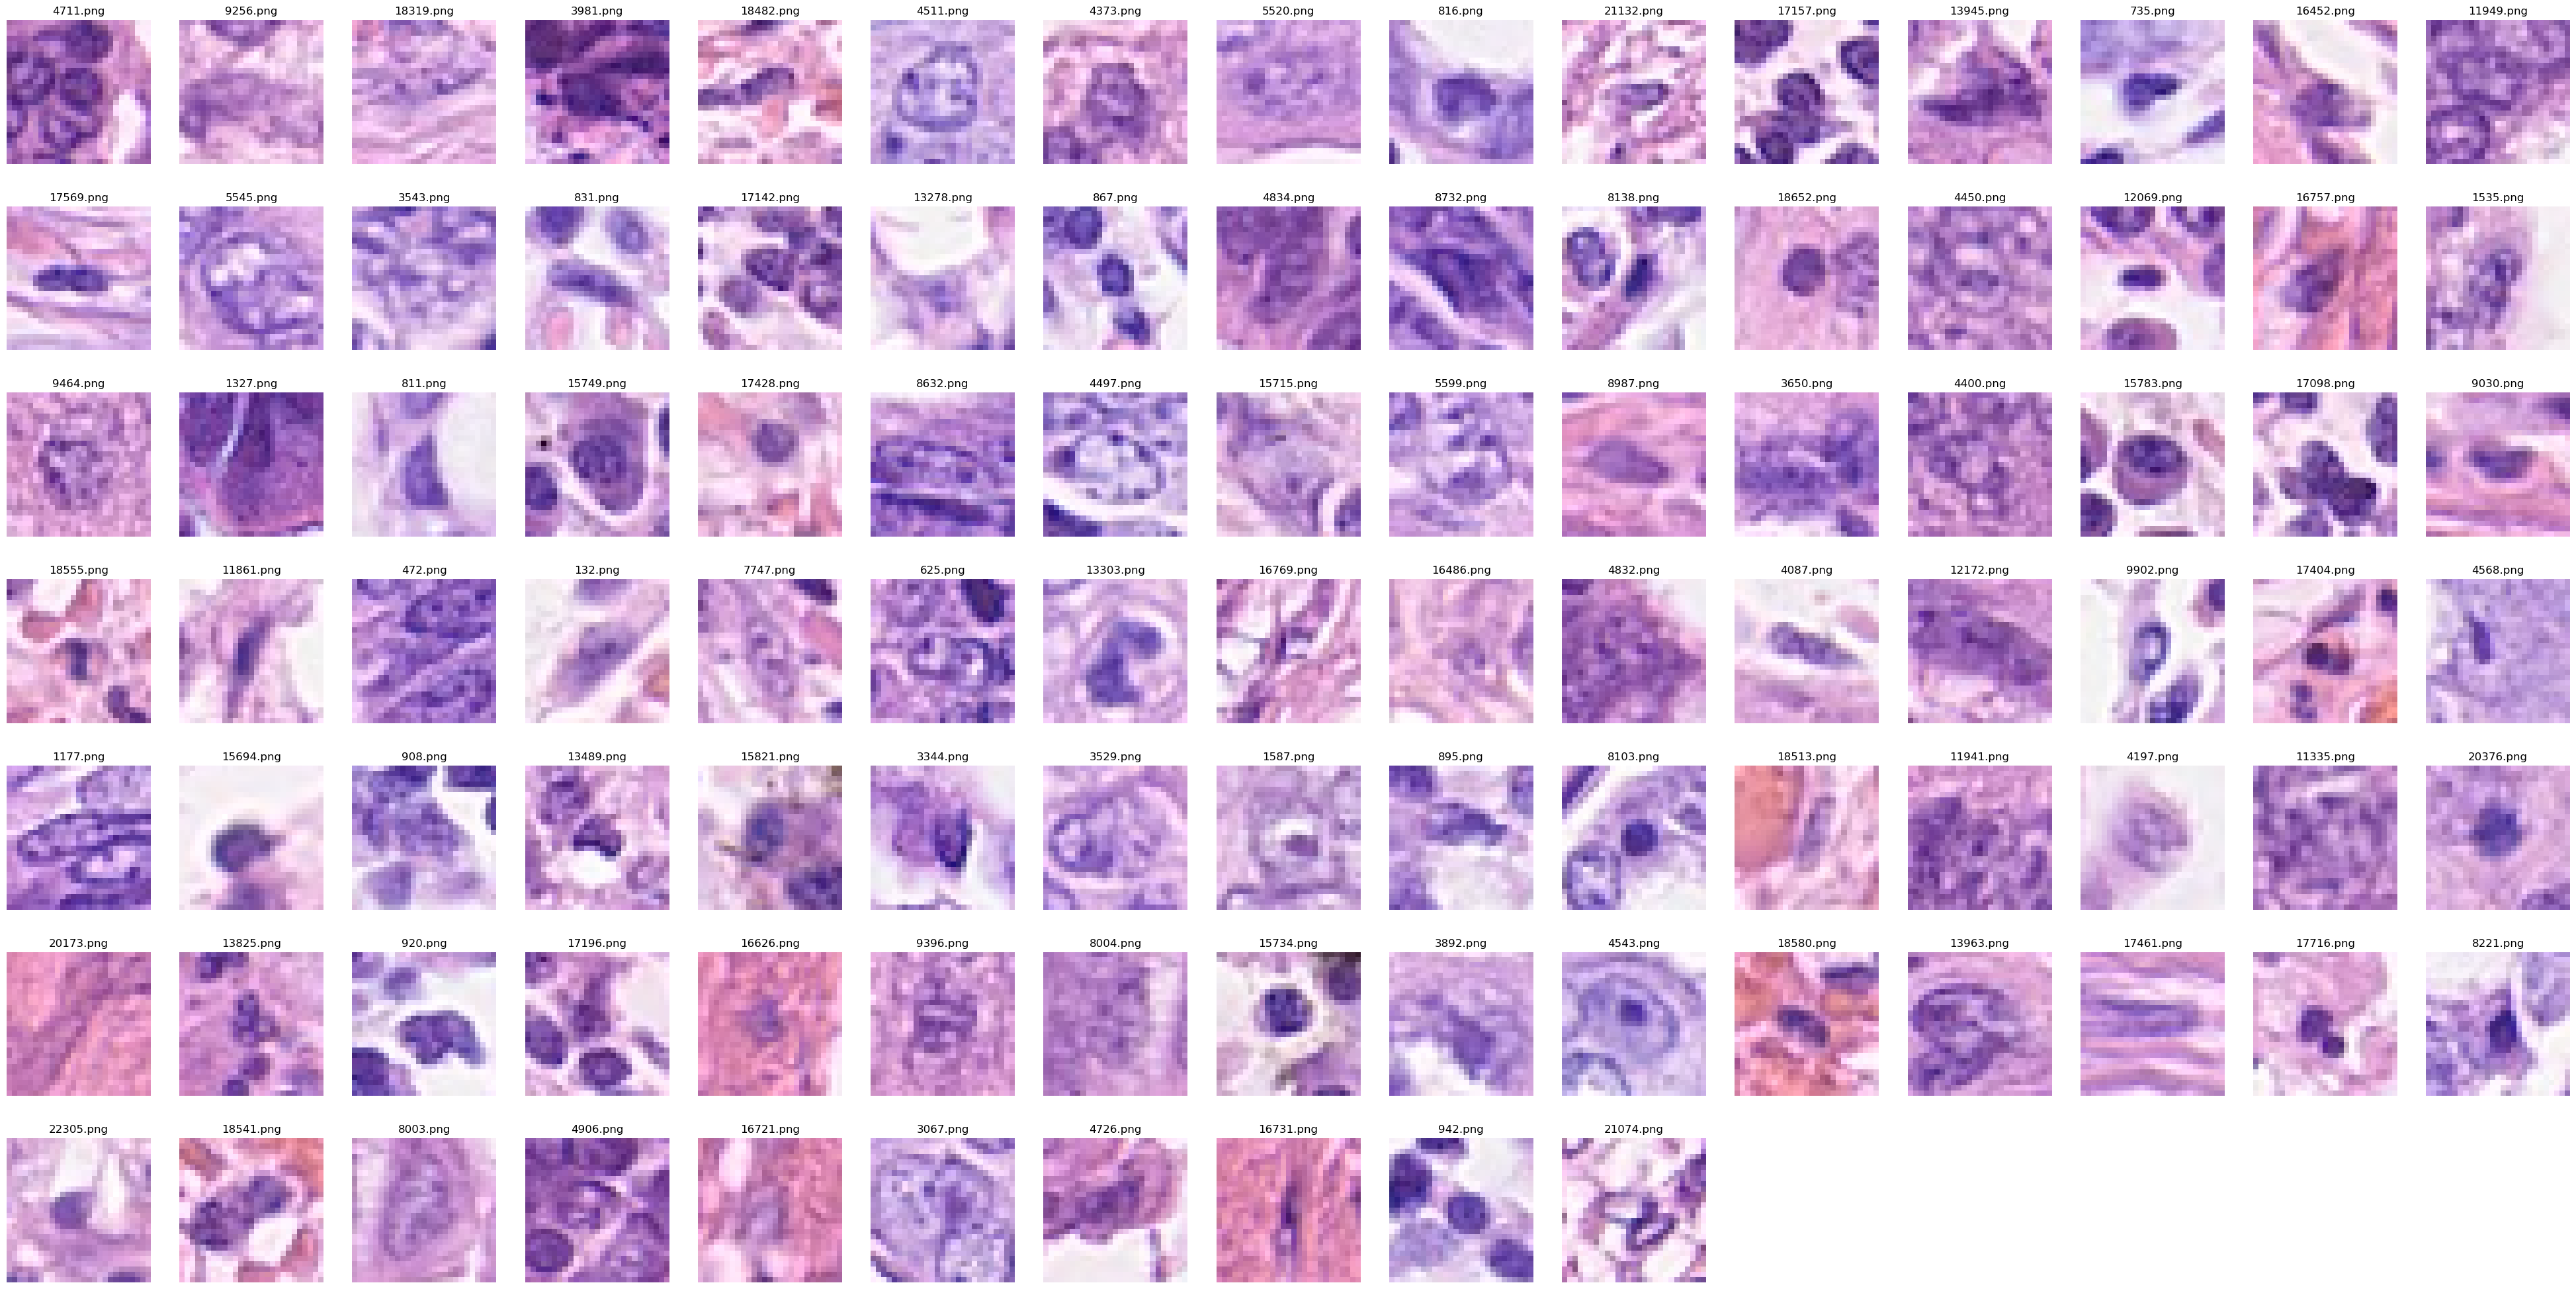

In [8]:
# A function to display cells images from the given data
def show_images(data):
    plt.figure(figsize=(50,25))
    count = 0
    for row in data.iterrows():
        image_path = './Image_classification_data/patch_images/' + row[1]['ImageName']
        image = tf.keras.preprocessing.image.load_img(image_path)
        plt.subplot(7,15, count + 1)
        plt.axis("off")
        plt.imshow(np.array(image).astype("uint8"))
        count += 1
        plt.title(row[1]['ImageName'])



sample_size = 100
sample_data = dataset.sample(sample_size, random_state=RANDOM_STATE)
show_images(sample_data)

Even though the `sample_dataset` is a very small subset of the `dataset`. it is clear that the images are very different from each other. Some images are very dark, some are very bright, some are very blurry, and some are very clear. Thus, it fair to assume that `dataset` does not contain any duplicate images. This is a very good sign as it shows that the dataset is very diverse and will help the machine learning model to learn better.

## Class Type Distribution <a id="class_type_distribution"></a>

As an image classification problem, it is important to understand the distribution of the classes in the dataset. Classes can be identified by finding the unique values from dataset's target column.

In [9]:
columns = ['isCancerous', 'cellTypeName']
class_types = {}
for ele in columns:
    class_types[ele] = dataset[ele].unique()
    print(f""" Unique values for column '{ele}' are: {np.array2string(dataset[ele].unique(), separator=', ')}""")

 Unique values for column 'isCancerous' are: [0, 1]
 Unique values for column 'cellTypeName' are: ['fibroblast', 'inflammatory', 'others', 'epithelial']


There are total of 2 classes for the machine learning model which will predict if the given cell image is cancerous or not. The classes are `cancerous` and `non-cancerous` represented by `1` and `0` respectively from the `isCancerous` column in the dataset. 

For the machine learning model which will predict the cell type of the given cell image, there are total of 4 classes. The classes are `fibroblast`, `inflammatory`, `epithelial`, and `others` represented by `0`, `1`, `2`, and `3` respectively from 'cellType` column in the dataset.

# Data Distribution <a id="data_distribution"></a>

Data distribution allows to understand the sparseness of a dataset. From a image classification perspective, it is important to identify how the data is distributed across the class types. This is because, if a machine learning model is trained on a dataset which does not have an even distribution of classes, then the model will be biased towards a class with more data. Hence, increasing the biasness of a model and chances of miss-classification.

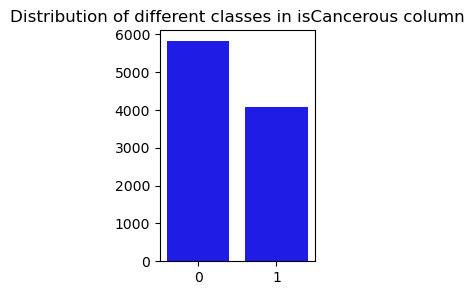

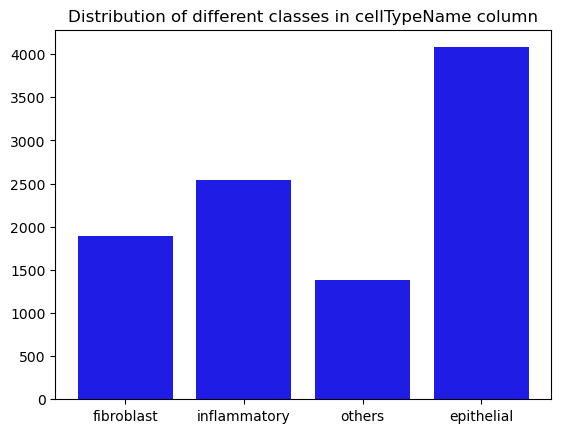

In [10]:
plt.figure(figsize=(2,3))
for ele in class_types.keys():
    isCancerous_distribution = {}
    for class_type in class_types[ele]:
        isCancerous_distribution[class_type] = len(dataset[dataset[ele] == class_type])
    plt.bar(range(len(isCancerous_distribution)), list(isCancerous_distribution.values()), color="#1F1CE5")
    plt.xticks(range(len(isCancerous_distribution)), list(isCancerous_distribution.keys()))
    plt.title(f'Distribution of different classes in {ele} column')
    plt.show()

The bar graphs from above suggest that the dataset is not evenly distributed across all the classes.

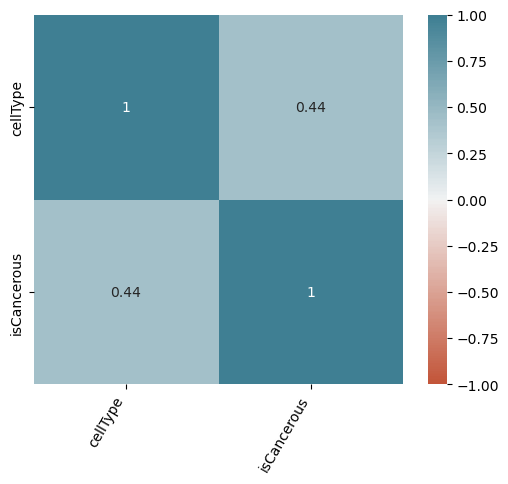

In [11]:
corr = dataset.corr()
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, 
    center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
#     linewidths=0.01
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=60,
    horizontalalignment='right'
);

# Data Cleaning <a id="data_cleaning"></a>

When working with categorical data, it is vital to convert any categorical data into string datatype, so that the model can identify these values as categorical values. 

In [12]:
dataset['isCancerous'] = dataset['isCancerous'].astype('str')
dataset['cellType'] = dataset['cellType'].astype('str')

# Data Splitting <a name="data_splitting"></a>

Before providing the dataset to the machine learning model, it is necessary to split the dataset into training, validation and test. Both validation and test dataset are unseen data for the machine learning model. These dataset needs to be unseen because to evaluate the performance of the model, the model needs to predict on unseen data. Furthermore, the validation dataset is used to tune and find the best hyperparameters of the model.

Since the number of instances in the dataset is about 9900, the dataset will be split into 80% train dataset, 10% test dataset and 20% validation dataset. The rationale behind splitting into this ratios is because to have a training dataset as large as possible without compromising the size of the test and validation datasets. 

In [13]:
dataset_size = dataset.shape[0]

test_dataset_ratio = 0.10
validation_dataset_ratio = 0.20

train_data, test_data = train_test_split(dataset, test_size=test_dataset_ratio , random_state=RANDOM_STATE)
train_data, val_data = train_test_split(train_data, test_size=validation_dataset_ratio, random_state=RANDOM_STATE)

print(f"Number of rows in training dataset: {train_data.shape[0]} rows\n" +
      f"Number of rows in validation dataset: {val_data.shape[0]} rows\n" +
      f"Number of rows in test dataset: {test_data.shape[0]} rows")

Number of rows in training dataset: 7124 rows
Number of rows in validation dataset: 1782 rows
Number of rows in test dataset: 990 rows


# Data Pre-processing

In [14]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

# Performance Evaluation <a id="performace_evaluation"></a>

After training a machine learning model, there needs to be a way to evaluate the performance of the model. This is important because it allows to compare the performance of different models on a standardized metric. In addition, it also allows to understand if the model is either under-fitting, over-fitting or just right. 

Under-fitting is when the model is not able to learn the patterns with in the dataset, whereas, over-fitting is when the model learns the patterns too well and is not able to generalize on unseen data. A performance metric lets to compare the metric between the train and validation dataset, allowing to identify if the model is under-fitting or over-fitting.

There are many different performance metrics that can be used to evaluate the performance of a image classification machine learning models. For this report, a combination of following performance metrics will be used to determine the performance of the machine learning models:
    
- Accuracy: This performance metric is the most commonly used metric. It is calculated as the ratio of correctly predicted instances to the total number of instances in the dataset. This metric will suggest that the model is will under-fit if the accuracy is low on both the train and validation dataset. On the other hand, for the train dataset, if the accuracy is high and the validation dataset has low accuracy, then the model is over-fitting.
- F1 Score: This performance metric is the harmonic mean of precision and recall metric. Precision metric is a ration between the instances if true positive and the total instances predicted as positive. Recall metric is a ratio between the instances of true positive and the total instances that are actually positive. Hence, f1 score is calculated as $F1\ score = \frac{2 \cdot precision \cdot recall}{precision + recall}$. In essence, f1 score provides a balanced overview evaluation of the model's precision and recall.

In [15]:
def display_model_summary(model):
    model.summary()
    display(tf.keras.utils.plot_model(model, show_shapes=True))

In [16]:
performance_metrices = ['loss','roc']

In [17]:
def display_metric(history):
    VALUE_INDEX = -1
    for key in performance_metrices:
        print(key,"- train:",round(history[key][VALUE_INDEX],4),"val: ",round(history["val_"+key][VALUE_INDEX],4))

def plot_learning_curve(history):
    count = 1
    plt.figure(figsize=(10,5))
    for key in performance_metrices:
        plt.subplot(1,3,count)
        plt.plot(history[key], 'r--')
        plt.plot(history["val_"+key], 'b--')
        plt.xlabel("epochs")
        plt.ylabel(key)
        plt.legend(['train', 'validation'], loc='upper left')
        plt.ylim([min(min(history[key]), min(history["val_" + key]))-0.05,
                  max(max(history[key]), max(history["val_" + key]))+0.05])
        plt.tight_layout(pad=1.5)
        count += 1
    plt.show()

# Need to explain that

In [18]:
INPUT_DIM = (27,27,3) # Height, Width, Channels
IS_CANCEROUS_CLASS_OUTPUT_COUNT = len(class_types['isCancerous'])

In [19]:
def get_data_generators(train_data,val_data,y_col,train_datagen=None,val_datagen=None,BATCH_SIZE=32):
    
    if train_datagen == None:
        train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
    if val_datagen == None:
        val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
    
    train_generator = train_datagen.flow_from_dataframe(
            dataframe=train_data,
            directory=ALL_IMAGES_DIR,
            x_col="ImageName",
            y_col=y_col,
            target_size=(INPUT_DIM[0],INPUT_DIM[1]),
            batch_size=BATCH_SIZE,
            class_mode='categorical')

    validation_generator = val_datagen.flow_from_dataframe(
            dataframe=val_data,
            directory=ALL_IMAGES_DIR,
            x_col="ImageName",
            y_col=y_col,
            target_size=(INPUT_DIM[0],INPUT_DIM[1]),
            batch_size=BATCH_SIZE,
            class_mode='categorical')
    
    return train_generator, validation_generator

# Baseline Model <a id="baseline_model"></a>

Baseline model is an initial step to create a working machine learning model. 

In [20]:
train_generator, validation_generator = get_data_generators(train_data,val_data,y_col='isCancerous')

Found 7124 validated image filenames belonging to 2 classes.
Found 1782 validated image filenames belonging to 2 classes.


In [21]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(IS_CANCEROUS_CLASS_OUTPUT_COUNT),
])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2187)              0         
                                                                 
 dense (Dense)               (None, 32)                70016     
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 70,082
Trainable params: 70,082
Non-trainable params: 0
_________________________________________________________________


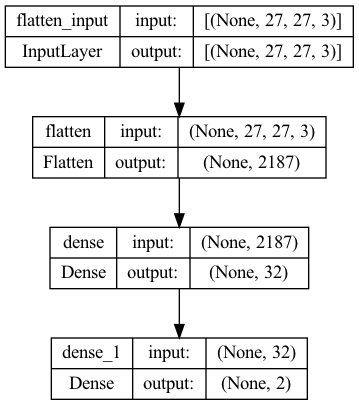

In [22]:
display_model_summary(model_1)

In [23]:
model_1.compile(optimizer='SGD',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.AUC(from_logits=True,name="roc")])

In [24]:
model_history_1 = model_1.fit(train_generator, validation_data = validation_generator, epochs=100, verbose=1)

Epoch 1/100
223/223 [==============================] - 3s 10ms/step - loss: 0.6042 - roc: 0.7419 - val_loss: 0.5707 - val_roc: 0.7809
Epoch 2/100
223/223 [==============================] - 1s 5ms/step - loss: 0.4780 - roc: 0.8766 - val_loss: 0.4214 - val_roc: 0.9275
Epoch 3/100
223/223 [==============================] - 1s 5ms/step - loss: 0.4193 - roc: 0.8971 - val_loss: 0.3923 - val_roc: 0.9077
Epoch 4/100
223/223 [==============================] - 1s 5ms/step - loss: 0.3891 - roc: 0.9086 - val_loss: 0.3433 - val_roc: 0.9363
Epoch 5/100
223/223 [==============================] - 1s 5ms/step - loss: 0.3593 - roc: 0.9218 - val_loss: 0.4234 - val_roc: 0.8889
Epoch 6/100
223/223 [==============================] - 1s 5ms/step - loss: 0.3540 - roc: 0.9231 - val_loss: 0.3221 - val_roc: 0.9388
Epoch 7/100
223/223 [==============================] - 1s 5ms/step - loss: 0.3517 - roc: 0.9237 - val_loss: 0.3637 - val_roc: 0.9183
Epoch 8/100
223/223 [==============================] - 1s 6ms/step -

223/223 [==============================] - 1s 5ms/step - loss: 0.2821 - roc: 0.9514 - val_loss: 0.3335 - val_roc: 0.9331
Epoch 63/100
223/223 [==============================] - 1s 5ms/step - loss: 0.2786 - roc: 0.9525 - val_loss: 0.3041 - val_roc: 0.9433
Epoch 64/100
223/223 [==============================] - 1s 5ms/step - loss: 0.2786 - roc: 0.9527 - val_loss: 0.3212 - val_roc: 0.9376
Epoch 65/100
223/223 [==============================] - 1s 5ms/step - loss: 0.2749 - roc: 0.9540 - val_loss: 0.3468 - val_roc: 0.9285
Epoch 66/100
223/223 [==============================] - 1s 5ms/step - loss: 0.2765 - roc: 0.9534 - val_loss: 0.3024 - val_roc: 0.9438
Epoch 67/100
223/223 [==============================] - 1s 5ms/step - loss: 0.2746 - roc: 0.9542 - val_loss: 0.3133 - val_roc: 0.9398
Epoch 68/100
223/223 [==============================] - 1s 5ms/step - loss: 0.2759 - roc: 0.9537 - val_loss: 0.3094 - val_roc: 0.9413
Epoch 69/100
223/223 [==============================] - 1s 5ms/step - loss:

loss - train: 0.2501 val:  0.297
roc - train: 0.9621 val:  0.9458


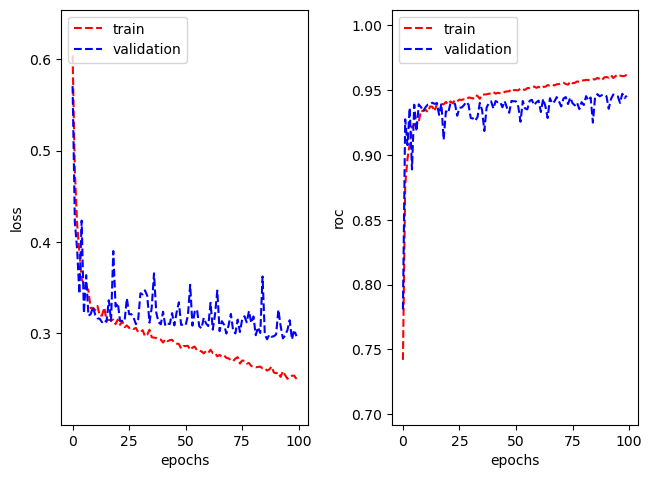

In [25]:
display_metric(model_history_1.history)
plot_learning_curve(model_history_1.history)

## Model 2: CNN (Convolutional Neural Networks)

In [26]:
train_generator, validation_generator = get_data_generators(train_data,val_data,y_col='isCancerous')

Found 7124 validated image filenames belonging to 2 classes.
Found 1782 validated image filenames belonging to 2 classes.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 128)       

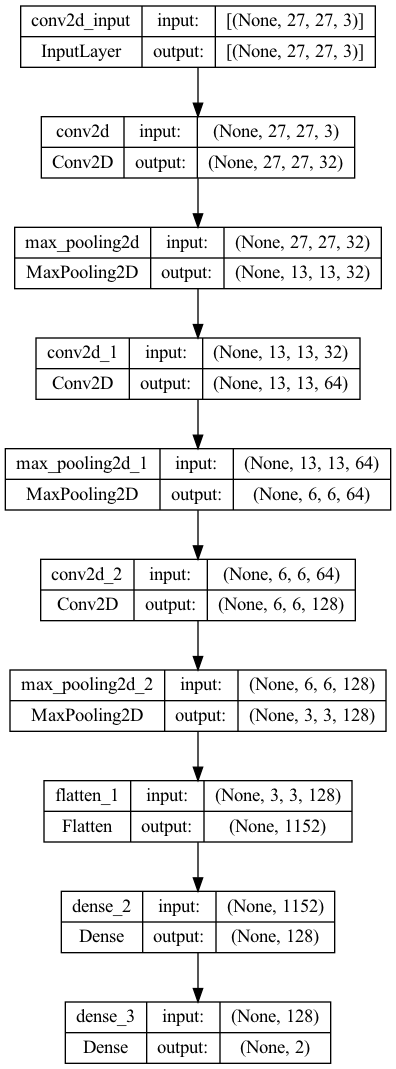

In [27]:
model_2 = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(IS_CANCEROUS_CLASS_OUTPUT_COUNT),
])

display_model_summary(model_2)

In [28]:
model_2.compile(optimizer='SGD',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.AUC(from_logits=True,name="roc")])

In [29]:
model_history_2 = model_2.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=1)

Epoch 1/25
223/223 [==============================] - 3s 14ms/step - loss: 0.6709 - roc: 0.6365 - val_loss: 0.6697 - val_roc: 0.7382
Epoch 2/25
223/223 [==============================] - 3s 14ms/step - loss: 0.6590 - roc: 0.7122 - val_loss: 0.6551 - val_roc: 0.7564
Epoch 3/25
223/223 [==============================] - 3s 14ms/step - loss: 0.6341 - roc: 0.7346 - val_loss: 0.6073 - val_roc: 0.7732
Epoch 4/25
223/223 [==============================] - 3s 13ms/step - loss: 0.5745 - roc: 0.7818 - val_loss: 0.5461 - val_roc: 0.8005
Epoch 5/25
223/223 [==============================] - 3s 15ms/step - loss: 0.5289 - roc: 0.8146 - val_loss: 0.4299 - val_roc: 0.9069
Epoch 6/25
223/223 [==============================] - 3s 14ms/step - loss: 0.4991 - roc: 0.8381 - val_loss: 0.4665 - val_roc: 0.8595
Epoch 7/25
223/223 [==============================] - 3s 15ms/step - loss: 0.4667 - roc: 0.8601 - val_loss: 0.3850 - val_roc: 0.9216
Epoch 8/25
223/223 [==============================] - 3s 14ms/step - 

loss - train: 0.2988 val:  0.2754
roc - train: 0.9454 val:  0.9561


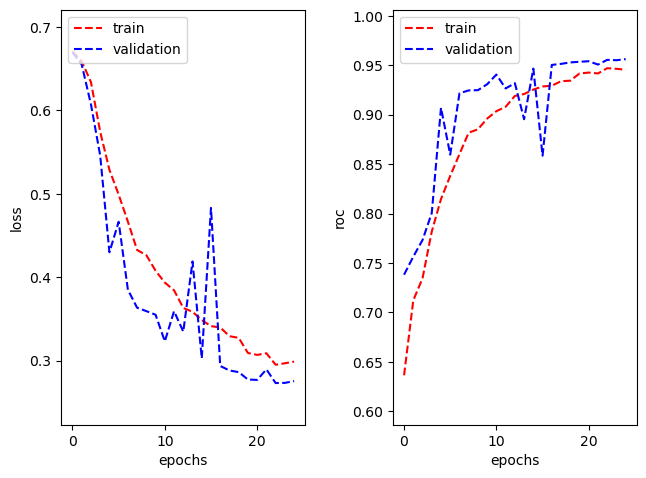

In [30]:
display_metric(model_history_2.history)
plot_learning_curve(model_history_2.history)

# Regularisation and Hyper Parameter Tuning

In [31]:
train_generator, validation_generator = get_data_generators(train_data,val_data,y_col='isCancerous')

Found 7124 validated image filenames belonging to 2 classes.
Found 1782 validated image filenames belonging to 2 classes.


(KerasTuner) Referenced from - https://colab.research.google.com/github/keras-team/keras-io/blob/master/guides/ipynb/keras_tuner/getting_started.ipynb#scrollTo=A4jPeCcknwkV

In [32]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(
        hp.Choice('conv1_filters', values=[32,64, 128]), 
        (3, 3), 
        activation='relu', 
        padding='same', 
        input_shape=INPUT_DIM))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    
    model.add(tf.keras.layers.Conv2D(
        hp.Choice('conv1_filters', values=[32,64, 128])*2, 
        (3, 3), 
        activation='relu', 
        padding='same'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    
    model.add(tf.keras.layers.Conv2D(
        hp.Choice('conv1_filters', values=[32,64, 128])*4, 
        (3, 3), 
        activation='relu', 
        padding='same'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(
        units=hp.Choice('conv1_filters', values=[32,64, 128])*4, 
        activation='relu'))

    model.add(tf.keras.layers.Dense(IS_CANCEROUS_CLASS_OUTPUT_COUNT))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")), # hp.Choice("optimizer", ["adam"]),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=[tf.keras.metrics.AUC(from_logits=True,name="roc")])
        
    return model


# Building the Model for Hyper Parameter tuning
build_model(keras_tuner.HyperParameters())

In [33]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective=keras_tuner.Objective('val_roc', direction='max'),  # Use validation AUC-ROC as the objective to optimize
    max_trials=15,  # Try different hyperparameter configurations
    executions_per_trial=1,  # Only train each model once to save time
    overwrite=True,
    directory='Tuner',  # Directory to store the search results
    project_name='task_1_tuner'  # Name of the search project
)

In [34]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
conv1_filters (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [35]:
tuner.search(train_generator,epochs=10,validation_data=validation_generator)

Trial 15 Complete [00h 01m 59s]
val_roc: 0.9668862819671631

Best val_roc So Far: 0.9684823751449585
Total elapsed time: 00h 41m 42s
INFO:tensorflow:Oracle triggered exit


In [36]:
tuner.results_summary()

Results summary
Results in Tuner/task_1_tuner
Showing 10 best trials
Objective(name="val_roc", direction="max")

Trial 05 summary
Hyperparameters:
conv1_filters: 32
learning_rate: 0.0007927569482609079
Score: 0.9684823751449585

Trial 09 summary
Hyperparameters:
conv1_filters: 128
learning_rate: 0.0004723041743755867
Score: 0.9680313467979431

Trial 12 summary
Hyperparameters:
conv1_filters: 64
learning_rate: 0.0005675925467086275
Score: 0.9676950573921204

Trial 02 summary
Hyperparameters:
conv1_filters: 128
learning_rate: 0.0006911425300961018
Score: 0.9674763679504395

Trial 07 summary
Hyperparameters:
conv1_filters: 32
learning_rate: 0.0010847808345956858
Score: 0.967437207698822

Trial 10 summary
Hyperparameters:
conv1_filters: 32
learning_rate: 0.0004933580644287955
Score: 0.967170774936676

Trial 14 summary
Hyperparameters:
conv1_filters: 64
learning_rate: 0.0005334545424135214
Score: 0.9668862819671631

Trial 01 summary
Hyperparameters:
conv1_filters: 32
learning_rate: 0.002576

In [37]:
model_3 = tuner.get_best_models(num_models=1)[0]

In [38]:
model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 128)        0

In [39]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [40]:
print(best_hps.values)

{'conv1_filters': 32, 'learning_rate': 0.0007927569482609079}


In [41]:
learning_rate = best_hps.values['learning_rate']

## Data Augmentation

In data augmentation, we randomly perterbate the original dataset to form a larger dataset and use that for training. 

The keras data generator can do this for us. However we need to pick the data augmentation techniques that are appropriate for the task. Lets see how this is done. We apply data augmentation only for trainig data (not for validation or test)

In [42]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                  rotation_range=30)
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

In [43]:
train_generator,validation_generator = get_data_generators(train_data,val_data,y_col='isCancerous',
                                                           train_datagen=train_datagen,
                                                           val_datagen=val_datagen)

Found 7124 validated image filenames belonging to 2 classes.
Found 1782 validated image filenames belonging to 2 classes.


In [44]:
model_3_history = model_3.fit(train_generator, validation_data = validation_generator, epochs=10, verbose=1)

Epoch 1/10
223/223 [==============================] - 5s 23ms/step - loss: 0.2333 - roc: 0.9666 - val_loss: 0.2762 - val_roc: 0.9537
Epoch 2/10
223/223 [==============================] - 5s 21ms/step - loss: 0.2433 - roc: 0.9639 - val_loss: 0.2145 - val_roc: 0.9720
Epoch 3/10
223/223 [==============================] - 5s 21ms/step - loss: 0.2242 - roc: 0.9691 - val_loss: 0.2165 - val_roc: 0.9714
Epoch 4/10
223/223 [==============================] - 5s 21ms/step - loss: 0.2266 - roc: 0.9683 - val_loss: 0.2276 - val_roc: 0.9685
Epoch 5/10
223/223 [==============================] - 5s 22ms/step - loss: 0.2252 - roc: 0.9688 - val_loss: 0.2553 - val_roc: 0.9615
Epoch 6/10
223/223 [==============================] - 5s 20ms/step - loss: 0.2077 - roc: 0.9734 - val_loss: 0.2288 - val_roc: 0.9684
Epoch 7/10
223/223 [==============================] - 5s 21ms/step - loss: 0.2125 - roc: 0.9722 - val_loss: 0.2168 - val_roc: 0.9712
Epoch 8/10
223/223 [==============================] - 5s 21ms/step - 

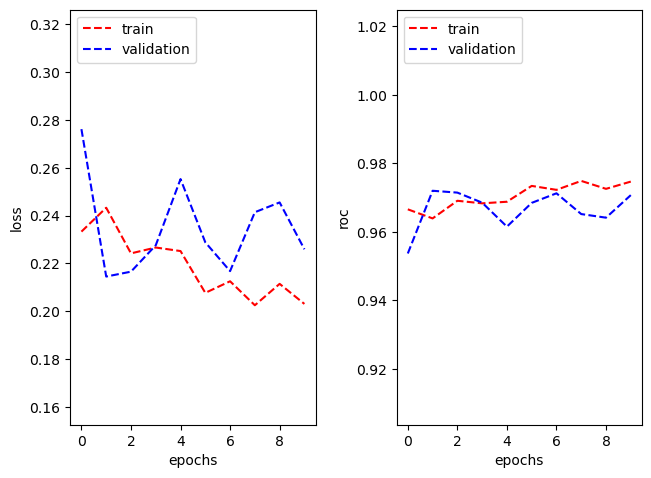

In [45]:
plot_learning_curve(model_3.history.history)

In [46]:
display_metric(model_3.history.history)

loss - train: 0.203 val:  0.2259
roc - train: 0.9747 val:  0.9707


In [47]:
model_3.save("task_1_model")

INFO:tensorflow:Assets written to: task_1_model/assets


INFO:tensorflow:Assets written to: task_1_model/assets


## Add history here using fit on the tuned model

# Task 2 : Classify images according to cell-type <a name="task2" />

In [48]:
ExtraDataFrame = pd.read_csv('./Image_classification_data/data_labels_extraData.csv')

In [49]:
shape_str = f"""The provied dataset contains: 
                            - {ExtraDataFrame.shape[0]} instances
                            - {ExtraDataFrame.shape[1]} attributes"""
print(shape_str)

The provied dataset contains: 
                            - 10384 instances
                            - 4 attributes


In [50]:
print(ExtraDataFrame.head(5))

   InstanceID  patientID  ImageName  isCancerous
0       12681         61  12681.png            0
1       12682         61  12682.png            0
2       12683         61  12683.png            0
3       12684         61  12684.png            0
4       12685         61  12685.png            0


In [51]:
ExtraDataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10384 entries, 0 to 10383
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   InstanceID   10384 non-null  int64 
 1   patientID    10384 non-null  int64 
 2   ImageName    10384 non-null  object
 3   isCancerous  10384 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 324.6+ KB


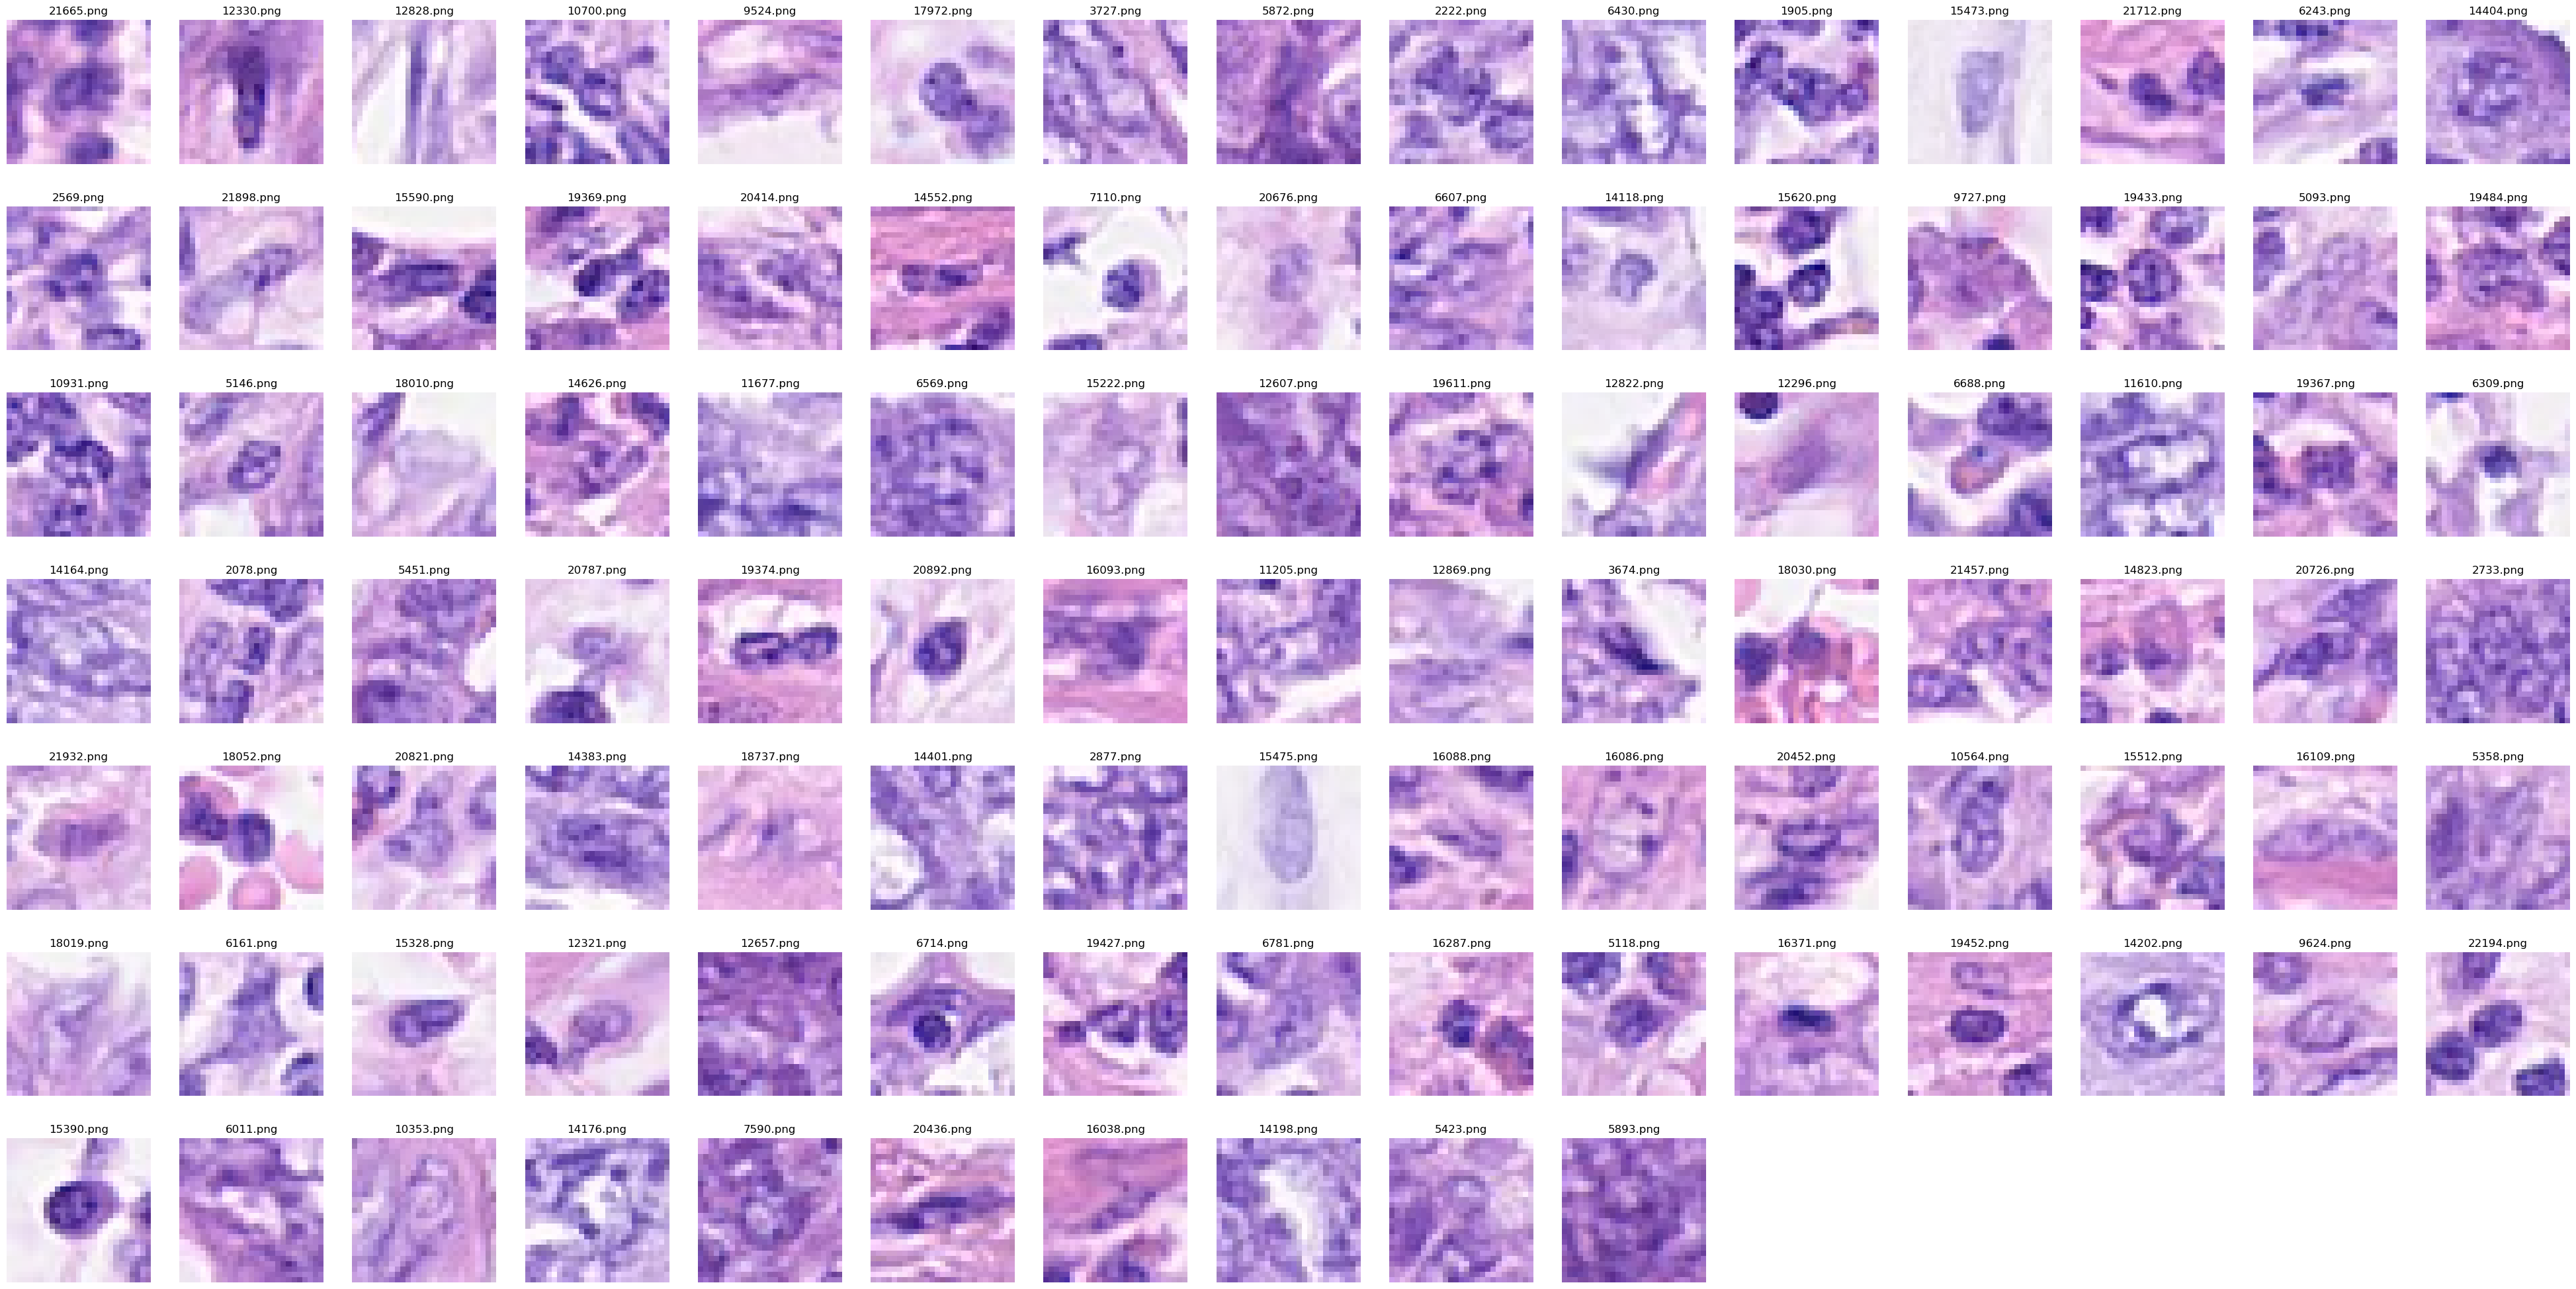

In [52]:
# visualize sample images

sample_size = 100
sample_data = ExtraDataFrame.sample(sample_size, random_state=RANDOM_STATE)
show_images(sample_data)

In [53]:
# Source directory containing all images
src_dir = ALL_IMAGES_DIR

# Destination directory to copy images
dst_dir = './Image_classification_data/unlabelled_patch_images/images'

if not os.path.exists(dst_dir):
    # If it doesn't exist, create it
    os.makedirs(dst_dir)

# Iterate through each row in the dataframe
for img_name in ExtraDataFrame['ImageName']:
    
    # Construct the source and destination paths
    src_path = os.path.join(src_dir, img_name)
    
    # Copy the image from the source path to the destination path
    shutil.copy(src_path, dst_dir)

In [54]:
train_data['cellType'] = train_data['cellType'].astype('str')

In [55]:
performance_metrices = ['loss','f1_score']

In [56]:
CELL_TYPE_CLASS_OUTPUT_COUNT = len(class_types['cellTypeName'])

# Model 3 : Tuned Model

Using model from task 1 using Transfer Learning

In [57]:
train_generator,validation_generator = get_data_generators(train_data,val_data,y_col='cellType')

Found 7124 validated image filenames belonging to 4 classes.
Found 1782 validated image filenames belonging to 4 classes.


In [58]:
model_3 = tf.keras.models.load_model('task_1_model')

In [59]:
model_3.pop()

In [60]:
for layer in model_3.layers: layer.trainable = False

# Model 4

## Add New Output Layer

In [61]:
model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 128)        0

In [62]:
# Add a new output layer for the new task
new_output_layer = tf.keras.layers.Dense(CELL_TYPE_CLASS_OUTPUT_COUNT, activation='softmax', name='output_layer')(model_3.layers[-1].output)

In [63]:
# Create the new model with the pre-trained layers and the new output layer
model_4 = tf.keras.Model(inputs=model_3.input, outputs=new_output_layer)

In [64]:
# Compile the model with a suitable optimizer, loss function, and metrics
model_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tfa.metrics.F1Score(num_classes=CELL_TYPE_CLASS_OUTPUT_COUNT, average='macro')])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 27, 27, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 27, 27, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 128)         73856 

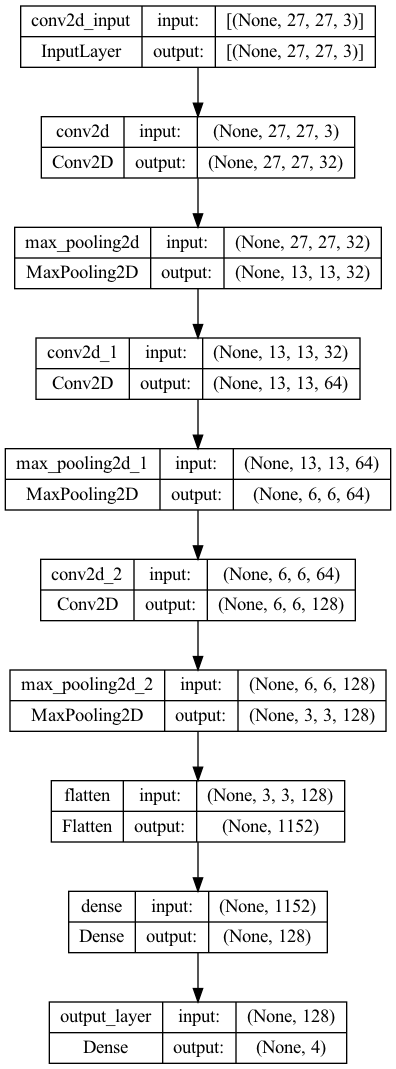

In [65]:
display_model_summary(model_4)

In [66]:
# Train the model with the new dataset
model_4_history = model_4.fit(train_generator, validation_data = validation_generator, epochs=10, verbose=1)

Epoch 1/10
223/223 [==============================] - 3s 11ms/step - loss: 0.9418 - f1_score: 0.4411 - val_loss: 0.7717 - val_f1_score: 0.5849
Epoch 2/10
223/223 [==============================] - 2s 7ms/step - loss: 0.7050 - f1_score: 0.5922 - val_loss: 0.7212 - val_f1_score: 0.6125
Epoch 3/10
223/223 [==============================] - 2s 8ms/step - loss: 0.6706 - f1_score: 0.6174 - val_loss: 0.7103 - val_f1_score: 0.5514
Epoch 4/10
223/223 [==============================] - 2s 9ms/step - loss: 0.6591 - f1_score: 0.6075 - val_loss: 0.7023 - val_f1_score: 0.5922
Epoch 5/10
223/223 [==============================] - 2s 8ms/step - loss: 0.6516 - f1_score: 0.6226 - val_loss: 0.7009 - val_f1_score: 0.5928
Epoch 6/10
223/223 [==============================] - 2s 7ms/step - loss: 0.6467 - f1_score: 0.6162 - val_loss: 0.6984 - val_f1_score: 0.6497
Epoch 7/10
223/223 [==============================] - 1s 7ms/step - loss: 0.6428 - f1_score: 0.6269 - val_loss: 0.6936 - val_f1_score: 0.5956
Epoch

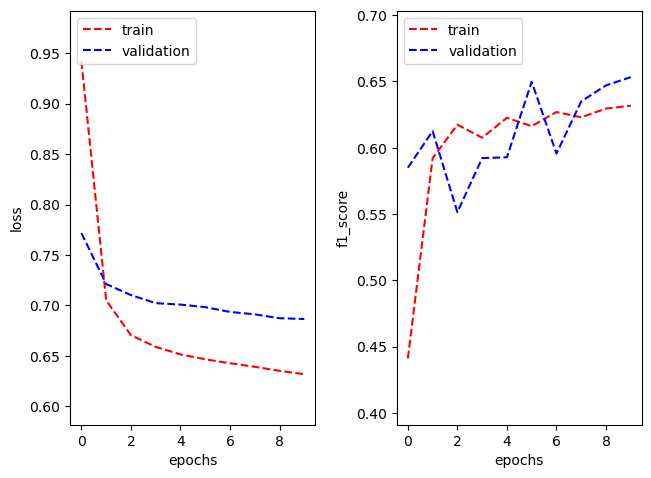

loss - train: 0.6319 val:  0.6866
f1_score - train: 0.6317 val:  0.6533


In [67]:
plot_learning_curve(model_4_history.history)
display_metric(model_4_history.history)

# Semi-supervised Learning

 1. Train the model using labelled dataset: model.fit
 2. Predict the unlabelled images using the trained model: model.predict
     a. Put the pseudo labels mapped with the unlabelled images
 3. Combine the labelled + unlabelled dataset
 4. Repeat task 1
 5. Analyse the performance metrix
 6. Unfreeze few/all layers and repeat process 1-5

In [68]:
model_5 = model_4

In [69]:
BATCH_SIZE = 32

In [70]:
train_generator,validation_generator = get_data_generators(train_data,val_data,
                                                           y_col='cellType',
                                                           BATCH_SIZE=BATCH_SIZE)

Found 7124 validated image filenames belonging to 4 classes.
Found 1782 validated image filenames belonging to 4 classes.


In [71]:
def generate_unlabelled_images():
    train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

    unlabelled_patch_images = './Image_classification_data/unlabelled_patch_images/'

    unlabelled_train_generator = train_datagen.flow_from_directory(
            unlabelled_patch_images,
            target_size=(INPUT_DIM[0],INPUT_DIM[1]),
            batch_size=BATCH_SIZE,
            class_mode='categorical')
    return unlabelled_train_generator

In [72]:
def get_pseudo_labels(unlabelled_predictions):
    pseudo_labels = tf.argmax(unlabelled_predictions, axis=-1)
    pseudo_labels = pseudo_labels.numpy().astype(int)

    return pseudo_labels

In [73]:
def generate_labelled_unlabelled_dataset(pseudo_labels):
    labelled_unlabelled = pd.DataFrame({
        'ImageName': np.concatenate([train_data['ImageName'].values, ExtraDataFrame['ImageName'].values]),
        'cellType': np.concatenate([train_data['cellType'].values, pseudo_labels])
    })
    labelled_unlabelled['cellType'] = labelled_unlabelled['cellType'].astype('str')
    return labelled_unlabelled

In [74]:
def get_train_generator(labelled_unlabelled):
    train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
    
    label_unlabel_train_gen = train_datagen.flow_from_dataframe(
            dataframe=labelled_unlabelled,
            directory=ALL_IMAGES_DIR,
            x_col="ImageName",
            y_col="cellType",
            target_size=(INPUT_DIM[0],INPUT_DIM[1]),
            batch_size=BATCH_SIZE,
            class_mode='categorical')
    return label_unlabel_train_gen

### Note: No unfreezing of layers has been done

Predicting the unlabelled images

In [75]:
# Compile the model with a suitable optimizer, loss function, and metrics
model_5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tfa.metrics.F1Score(num_classes=CELL_TYPE_CLASS_OUTPUT_COUNT, average='macro')])

In [76]:
# Use the model to make predictions on the unlabeled data
unlabelled_train_generator = generate_unlabelled_images()
unlabelled_predictions = model_5.predict(unlabelled_train_generator,verbose=1)

Found 10384 images belonging to 1 classes.
325/325 [==============================] - 2s 6ms/step


In [77]:
pseudo_labels = get_pseudo_labels(unlabelled_predictions)
labelled_unlabelled = generate_labelled_unlabelled_dataset(pseudo_labels)

Training model with combined dataset: labelled images + unlabelled images

In [78]:
label_unlabel_train_gen = get_train_generator(labelled_unlabelled)
model_5_history = model_5.fit(label_unlabel_train_gen, validation_data = validation_generator, epochs=10, verbose=1)

Found 17508 validated image filenames belonging to 4 classes.
Epoch 1/10
548/548 [==============================] - 4s 8ms/step - loss: 1.0944 - f1_score: 0.4483 - val_loss: 0.8513 - val_f1_score: 0.6162
Epoch 2/10
548/548 [==============================] - 4s 7ms/step - loss: 0.9627 - f1_score: 0.4568 - val_loss: 0.8783 - val_f1_score: 0.5947
Epoch 3/10
548/548 [==============================] - 4s 7ms/step - loss: 0.9589 - f1_score: 0.4564 - val_loss: 0.8683 - val_f1_score: 0.6013
Epoch 4/10
548/548 [==============================] - 4s 8ms/step - loss: 0.9554 - f1_score: 0.4614 - val_loss: 0.8824 - val_f1_score: 0.5936
Epoch 5/10
548/548 [==============================] - 3s 6ms/step - loss: 0.9528 - f1_score: 0.4676 - val_loss: 0.8510 - val_f1_score: 0.5948
Epoch 6/10
548/548 [==============================] - 4s 6ms/step - loss: 0.9502 - f1_score: 0.4615 - val_loss: 0.8155 - val_f1_score: 0.6144
Epoch 7/10
548/548 [==============================] - 3s 6ms/step - loss: 0.9492 - f1_

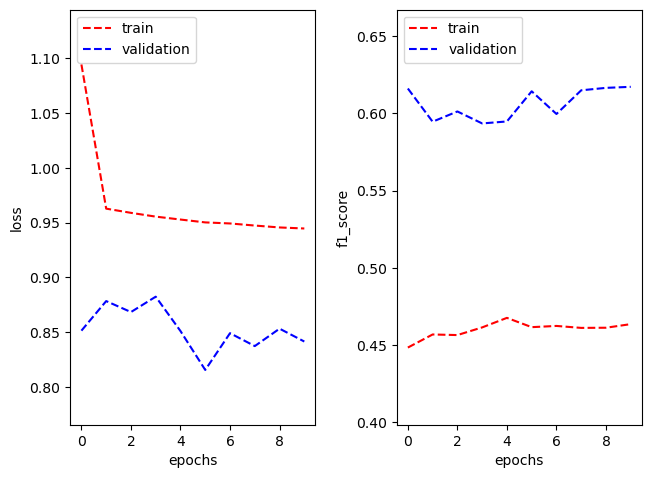

loss - train: 0.9446 val:  0.8414
f1_score - train: 0.4635 val:  0.6173


In [79]:
plot_learning_curve(model_5_history.history)
display_metric(model_5_history.history)

## To reduce Loss: Unfreezing 3 High level layers

In [80]:
for layer in model_5.layers[-3:]: layer.trainable = True

In [81]:
model_5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tfa.metrics.F1Score(num_classes=CELL_TYPE_CLASS_OUTPUT_COUNT, average='macro')])

In [82]:
# Train the model with the new dataset
model_5.fit(train_generator, validation_data = validation_generator, epochs=10, verbose=1)

Epoch 1/10
223/223 [==============================] - 2s 10ms/step - loss: 0.6105 - f1_score: 0.6641 - val_loss: 0.5962 - val_f1_score: 0.6899
Epoch 2/10
223/223 [==============================] - 2s 7ms/step - loss: 0.5451 - f1_score: 0.7014 - val_loss: 0.5807 - val_f1_score: 0.6951
Epoch 3/10
223/223 [==============================] - 2s 7ms/step - loss: 0.5125 - f1_score: 0.7214 - val_loss: 0.5843 - val_f1_score: 0.6980
Epoch 4/10
223/223 [==============================] - 2s 7ms/step - loss: 0.4928 - f1_score: 0.7338 - val_loss: 0.5842 - val_f1_score: 0.6981
Epoch 5/10
223/223 [==============================] - 2s 7ms/step - loss: 0.4791 - f1_score: 0.7415 - val_loss: 0.5965 - val_f1_score: 0.7164
Epoch 6/10
223/223 [==============================] - 2s 7ms/step - loss: 0.4629 - f1_score: 0.7561 - val_loss: 0.5812 - val_f1_score: 0.7161
Epoch 7/10
223/223 [==============================] - 2s 7ms/step - loss: 0.4498 - f1_score: 0.7613 - val_loss: 0.5894 - val_f1_score: 0.7068
Epoch

In [83]:
unlabelled_train_generator = generate_unlabelled_images()
unlabeled_predictions = model_5.predict(unlabelled_train_generator,verbose=1)

Found 10384 images belonging to 1 classes.
325/325 [==============================] - 3s 10ms/step


In [84]:
pseudo_labels = get_pseudo_labels(unlabelled_predictions)
labelled_unlabelled = generate_labelled_unlabelled_dataset(pseudo_labels)

In [85]:
label_unlabel_train_gen = get_train_generator(labelled_unlabelled)
model_5_history = model_5.fit(label_unlabel_train_gen, validation_data = validation_generator, epochs=10, verbose=1)

Found 17508 validated image filenames belonging to 4 classes.
Epoch 1/10
548/548 [==============================] - 4s 8ms/step - loss: 0.9101 - f1_score: 0.5455 - val_loss: 0.7350 - val_f1_score: 0.6651
Epoch 2/10
548/548 [==============================] - 4s 8ms/step - loss: 0.8517 - f1_score: 0.5643 - val_loss: 0.6968 - val_f1_score: 0.6916
Epoch 3/10
548/548 [==============================] - 4s 7ms/step - loss: 0.8371 - f1_score: 0.5732 - val_loss: 0.6946 - val_f1_score: 0.6818
Epoch 4/10
548/548 [==============================] - 4s 7ms/step - loss: 0.8231 - f1_score: 0.5777 - val_loss: 0.6947 - val_f1_score: 0.6818
Epoch 5/10
548/548 [==============================] - 4s 7ms/step - loss: 0.8142 - f1_score: 0.5823 - val_loss: 0.6847 - val_f1_score: 0.6856
Epoch 6/10
548/548 [==============================] - 5s 9ms/step - loss: 0.8014 - f1_score: 0.5928 - val_loss: 0.7204 - val_f1_score: 0.6651
Epoch 7/10
548/548 [==============================] - 4s 8ms/step - loss: 0.7900 - f1_

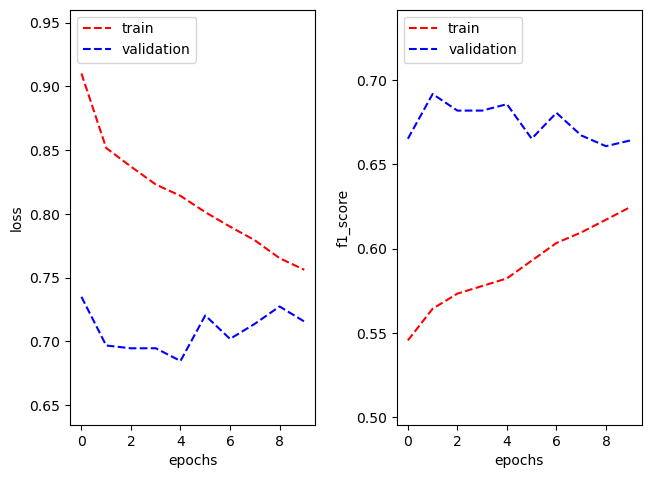

loss - train: 0.7562 val:  0.7156
f1_score - train: 0.6247 val:  0.6641


In [86]:
plot_learning_curve(model_5_history.history)
display_metric(model_5_history.history)

### Unfreezing next 4 top layers

In [87]:
for layer in model_5.layers[-5:]: layer.trainable = True

In [88]:
model_5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tfa.metrics.F1Score(num_classes=CELL_TYPE_CLASS_OUTPUT_COUNT, average='macro')])

In [89]:
# Train the model with the new dataset
model_5.fit(train_generator, validation_data = validation_generator, epochs=10, verbose=1)

Epoch 1/10
223/223 [==============================] - 3s 13ms/step - loss: 0.4096 - f1_score: 0.8000 - val_loss: 0.6303 - val_f1_score: 0.6953
Epoch 2/10
223/223 [==============================] - 3s 16ms/step - loss: 0.3336 - f1_score: 0.8423 - val_loss: 0.6292 - val_f1_score: 0.7101
Epoch 3/10
223/223 [==============================] - 3s 14ms/step - loss: 0.2989 - f1_score: 0.8620 - val_loss: 0.6451 - val_f1_score: 0.7060
Epoch 4/10
223/223 [==============================] - 4s 18ms/step - loss: 0.2529 - f1_score: 0.8857 - val_loss: 0.6792 - val_f1_score: 0.6994
Epoch 5/10
223/223 [==============================] - 4s 16ms/step - loss: 0.2219 - f1_score: 0.9021 - val_loss: 0.7147 - val_f1_score: 0.7082
Epoch 6/10
223/223 [==============================] - 4s 17ms/step - loss: 0.1875 - f1_score: 0.9217 - val_loss: 0.7303 - val_f1_score: 0.7072
Epoch 7/10
223/223 [==============================] - 4s 17ms/step - loss: 0.1608 - f1_score: 0.9371 - val_loss: 0.7607 - val_f1_score: 0.6990

In [90]:
unlabelled_train_generator = generate_unlabelled_images()
unlabeled_predictions = model_5.predict(unlabelled_train_generator,verbose=1)

Found 10384 images belonging to 1 classes.
325/325 [==============================] - 4s 11ms/step


In [91]:
pseudo_labels = get_pseudo_labels(unlabelled_predictions)
labelled_unlabelled = generate_labelled_unlabelled_dataset(pseudo_labels)

In [92]:
label_unlabel_train_gen = get_train_generator(labelled_unlabelled)
model_5_history = model_5.fit(label_unlabel_train_gen, validation_data = validation_generator, epochs=3, verbose=1)

Found 17508 validated image filenames belonging to 4 classes.
Epoch 1/3
548/548 [==============================] - 9s 16ms/step - loss: 0.7605 - f1_score: 0.6755 - val_loss: 0.7953 - val_f1_score: 0.6633
Epoch 2/3
548/548 [==============================] - 10s 18ms/step - loss: 0.6756 - f1_score: 0.7076 - val_loss: 0.8202 - val_f1_score: 0.6704
Epoch 3/3
548/548 [==============================] - 9s 16ms/step - loss: 0.6373 - f1_score: 0.7304 - val_loss: 0.8499 - val_f1_score: 0.6436


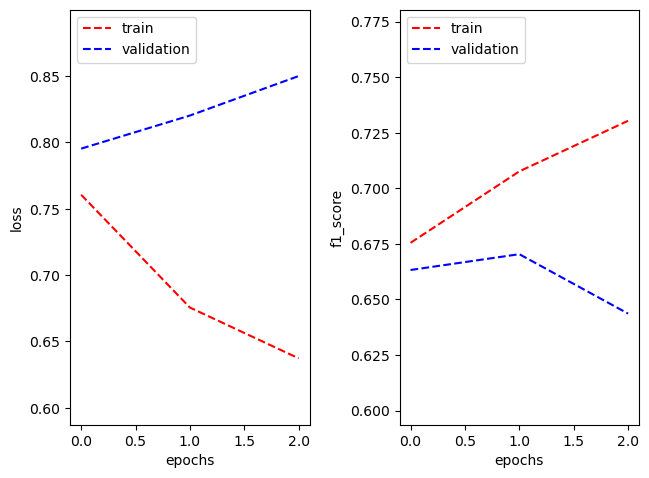

loss - train: 0.6373 val:  0.8499
f1_score - train: 0.7304 val:  0.6436


In [93]:
plot_learning_curve(model_5_history.history)
display_metric(model_5_history.history)